In [1]:
import sys
import os
_path = os.path.abspath('../scripts/')
if _path not in sys.path:
    sys.path.append(_path)

import astropy.coordinates as coord
coord.galactocentric_frame_defaults.set('v4.0')
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic
from scipy.special import logsumexp

from pyia import GaiaData
import theano
theano.config.gcc.cxxflags = "-fbracket-depth=16000" # default is 256
import pymc3 as pm
import theano.tensor as tt
import exoplanet as xo

from model import FieldHelper

Expected mean disk velocity in ICRS:

In [2]:
xtmp = coord.CartesianRepresentation(100, 0, 0, unit=u.km)
vlsr = coord.CartesianDifferential(-(np.array([12.9, 245.6, 7.78]) - np.array([0, 234, 0])) * u.km/u.s)
vthin = coord.SkyCoord(xtmp.with_differentials(vlsr), frame='galactic').icrs.velocity.d_xyz.value

xtmp = coord.CartesianRepresentation(100, 0, 0, unit=u.km)
vlsr = coord.CartesianDifferential(-(np.array([12.9, 245.6, 7.78]) - np.array([0, 200, 0])) * u.km/u.s)
vthik = coord.SkyCoord(xtmp.with_differentials(vlsr), frame='galactic').icrs.velocity.d_xyz.value

xtmp = coord.CartesianRepresentation(100, 0, 0, unit=u.km)
vsun = coord.CartesianDifferential(-np.array([12.9, 245.6, 7.78]) * u.km/u.s)
vhalo = coord.SkyCoord(xtmp.with_differentials(vsun), frame='galactic').icrs.velocity.d_xyz.value

vthin, vthik, vhalo

(array([ 1.72666906, 17.96839664, -5.97107496]),
 array([-15.0730518 ,  33.09260716, -31.36846921]),
 array([-113.89493924,  122.05855141, -180.76490601]))

In [3]:
vfield0 = np.stack([vthin, vthik, vhalo])
sigvfield0 = np.stack([np.full(3, 20), 
                       np.full(3, 50), 
                       np.full(3, 125)])

In [4]:
g = GaiaData('../data/150pc_MG12-result.fits.gz')

In [42]:
subg = g[np.isfinite(g.radial_velocity)]
subg = subg[np.random.choice(len(subg), size=4096, replace=False)]

15.97906056103374 -1.7996497438651322
33.356099845368185 18.438641079574637
20.722814480566676 -11.298073015815191
15.60540515497358 -1.4376669832696107
33.00050372279477 18.209607865641026
20.763582379454643 -11.265461951759153


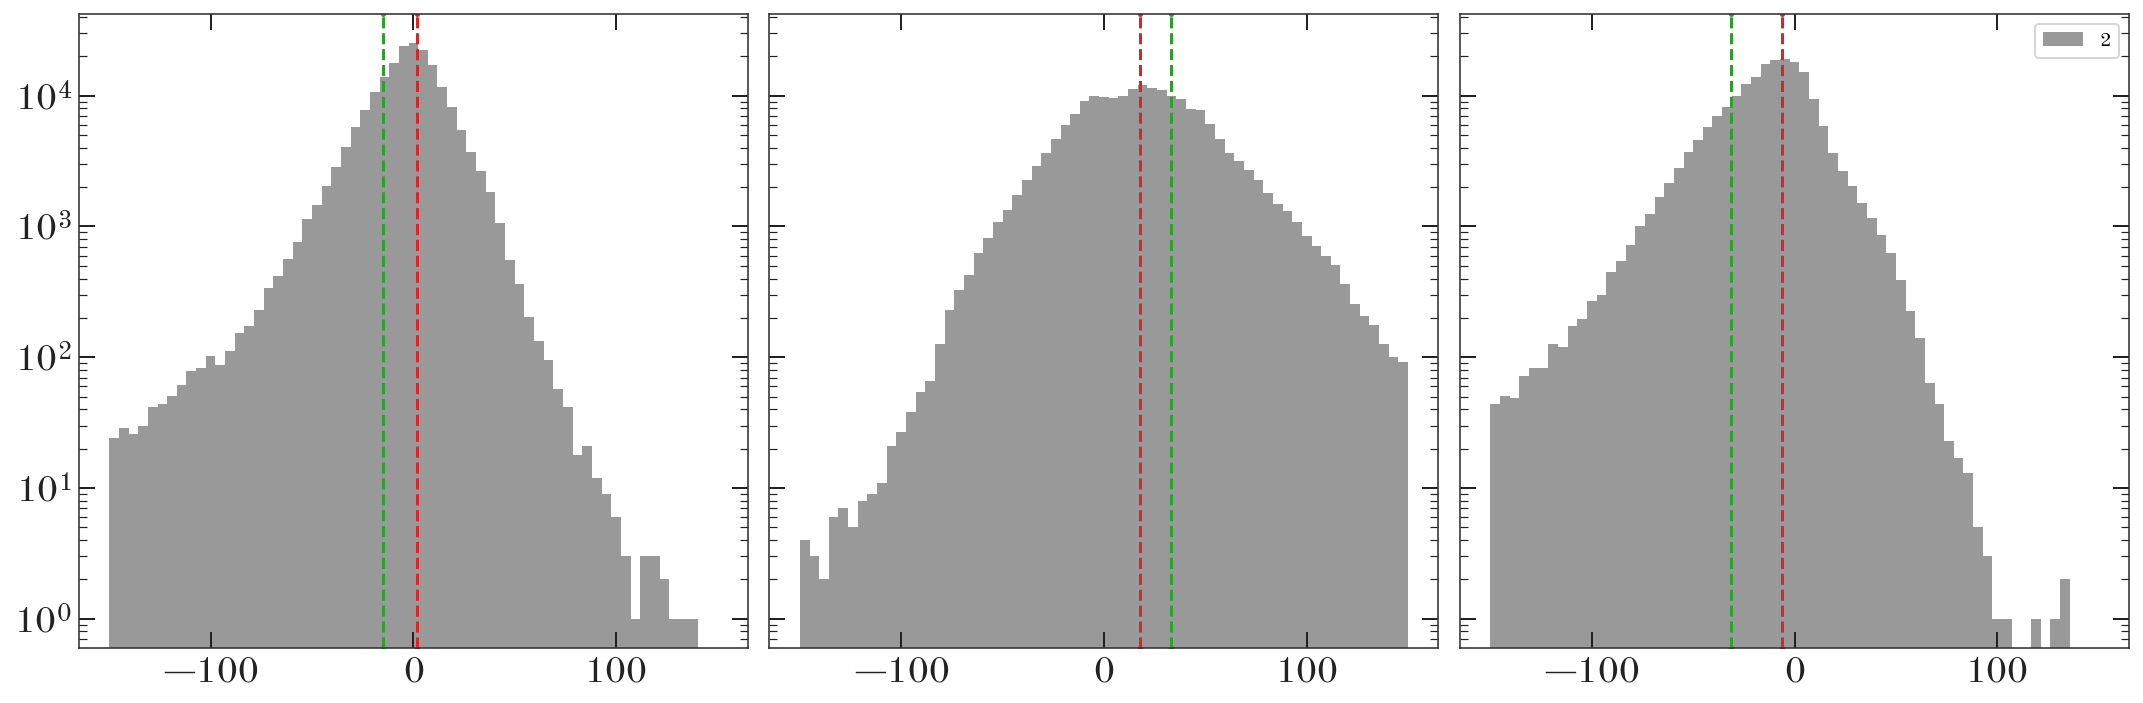

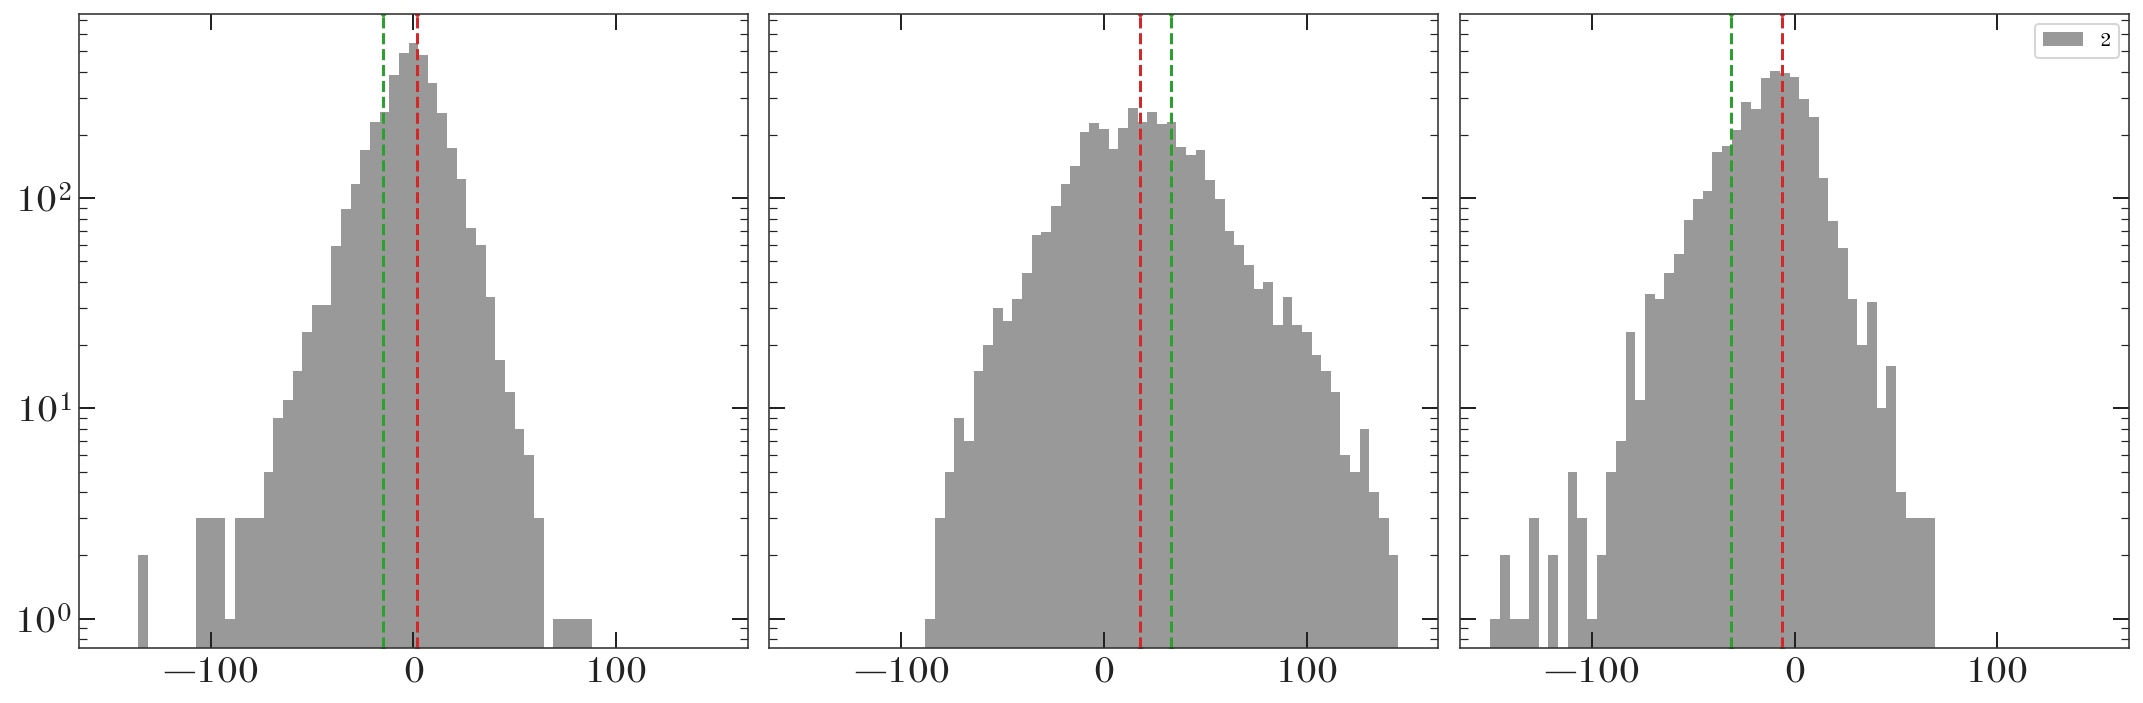

In [43]:
for gg in [g, subg]:
    c = gg.get_skycoord()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
    for i in range(3):
        ax = axes[i]

        _x = c.velocity.d_xyz.value[i]
        print(1.5 * np.nanmedian(np.abs(_x - np.nanmedian(_x))),
              np.nanmedian(_x))
        ax.hist(c.velocity.d_xyz.value[i],
                bins=np.linspace(-150, 150, 64), alpha=0.4, label=str(i));

        ax.axvline(vthin[i], color='tab:red', linestyle='--')
        ax.axvline(vthik[i], color='tab:green', linestyle='--')

    ax.legend(loc='best')
    ax.set_yscale('log')

    fig.tight_layout()

In [44]:
helper = FieldHelper(subg)
model = helper.get_model(vfield0, sigvfield0)

In [ ]:
with model:
    res = xo.optimize(start={'vxyz': helper.test_vxyz,
                             'r': helper.test_r,
                             'w': np.array([0.5, 0.4, 0.1])})

optimizing logp for variables: [vxyz, lns2, vmean2, lns1, vmean1, lns0, vmean0, w, r]


In [36]:
res['w']

array([0.64726703, 0.34544469, 0.00728828])